https://towardsdatascience.com/building-a-multi-label-text-classifier-using-bert-and-tensorflow-f188e0ecdc5d  
https://stackabuse.com/text-classification-with-bert-tokenizer-and-tf-2-0-in-python/  
https://towardsdatascience.com/building-a-multi-label-text-classifier-using-bert-and-tensorflow-f188e0ecdc5d   
https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff

In [33]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

import re, string, unicodedata
import random

from io import open

from bs4 import BeautifulSoup
from helper.contractions import CONTRACTION_MAP
from helper.slangs import SLANGS_MAP

import inflect
import unidecode
import emoji

import spacy
from spacy.lang.en import English
from spacy.tokenizer import Tokenizer
from spacy.lemmatizer import Lemmatizer

from spellchecker import SpellChecker
from nltk.tokenize import WhitespaceTokenizer

from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

#from keras.preprocessing.text import text_to_word_sequence

# global variables
wtk = WhitespaceTokenizer()

In [42]:
nlp = spacy.load('en_core_web_lg')
def spacy_tokenization_lemma(text):
    text_nlp = nlp(text)
    token_list = []
    for token in text_nlp:
        #token_list.append(token.text)
        if token.lemma_ != '-PRON-':
            token_list.append(token.lemma_)
        
    return token_list

##-- handle punctuations
def _remove_punct(text): 
    punctuations = '''!()-[]{};:'"\,<>/?@#$%^&*_~'''
    for x in text.lower(): 
        if x in string.punctuation: 
            text = text.replace(x, "")
  
    return text


def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_words.append(_remove_punct(word))
        
    return new_words


# convert emojis
def convert_emoji(text):
    text = emoji.demojize(text)
    return text


# remove html tags
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text


# remove URL from text
def remove_url(words):
    """Remove URLs from a sample string"""
    word_clean = []
    for word in words:
        text = re.sub(r"http\S+", "", word)
        if text:
            word_clean.append(text)
    return word_clean


### --- handle slangs
def unslang(text):
    """Convert slangs to corresponding english words"""
    wtk = WhitespaceTokenizer()
    words = wtk.tokenize(text)
    slangs = []
    for word in words:
        if word.upper() in SLANGS_MAP.keys():
            slangs.append(SLANGS_MAP[word.upper()])
        else:
            slangs.append(word)
            
    text_slangs = ' '.join(slangs)
    return text_slangs


def expand_contractions(text):
    wtk = WhitespaceTokenizer()
    words = wtk.tokenize(text)
    words_expand = []
    for word in words:
        if word in CONTRACTION_MAP.keys():
            words_expand.append(CONTRACTION_MAP[word])
        else:
            words_expand.append(word)
            
    text_expand = ' '.join(words_expand)
    return text_expand


##--- remove special characters
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text


# remove remianing non ascii characters
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words


### --- lemmatization
#lemmatizer = Lemmatizer(lookups)
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer(word)
        lemmas.append(lemma)
    return lemmas


###---- Remove stop words
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in spacy_stopwords:
            new_words.append(word)
    return new_words


# spell checker
spell = SpellChecker()
def correct_spellings(words):
    corrected_text = []
    misspelled_words = spell.unknown(words)
    for word in words:
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
            
    return corrected_text


def normalization(text):
    text = text.lower()
    text = convert_emoji(text)
    text = strip_html_tags(text)
    text = expand_contractions(text)
    text = unslang(text)
        
    # Tokenize
    words = spacy_tokenization_lemma(text)
    words = correct_spellings(words)
    words = remove_stopwords(words)
    words = remove_url(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    
    words = ' '.join(words)
    words = words.strip().lower()
    
    return words


In [2]:
train = pd.read_csv("data/train.csv", encoding='utf-8')
test = pd.read_csv("data/test.csv")
submission = pd.read_csv('data/SampleSubmission.csv')

In [3]:
train.dropna(axis=0, subset=('text', 'label'), inplace=True)
test.dropna(axis=0, subset=('text', ), inplace=True)

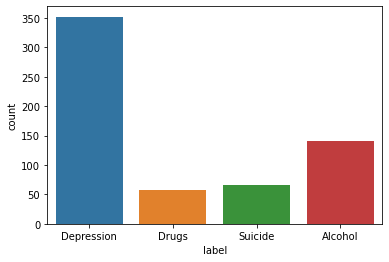

In [4]:
ax = sns.countplot(x='label', data=train)

In [43]:
%%time
train['text_norm'] = train['text'].apply(lambda x: normalization(x))

Wall time: 56.8 s


In [48]:
print(train.shape)
train.head()

(616, 4)


,ID,text,label,text_norm
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression,feel dream happy
1,9JDAGUV3,Why do I get hallucinations?,Drugs,hallucination
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression,stressed lack financial support school
3,6UY7DX6Q,Why is life important?,Suicide,life important
4,FYC0FTFB,How could I be helped to go through the depres...,Depression,help depression


In [45]:
%%time
test['text_norm'] = test['text'].apply(lambda x: normalization(x))

Wall time: 18.6 s


In [49]:
print(test.shape)
test.head()

(309, 3)


,ID,text,text_norm
0,02V56KMO,How to overcome bad feelings and emotions,overcome bad feeling emotion
1,03BMGTOK,I feel like giving up in life,feel like life
2,03LZVFM6,I was so depressed feel like got no strength t...,depressed feel like strength continue
3,0EPULUM5,I feel so low especially since I had no one to...,feel low especially talk
4,0GM4C5GD,can i be successful when I am a drug addict?,successful drug addict


## EXPLORATORY DATA

In [50]:
train['label'].unique()

array(['Depression', 'Drugs', 'Suicide', 'Alcohol'], dtype=object)

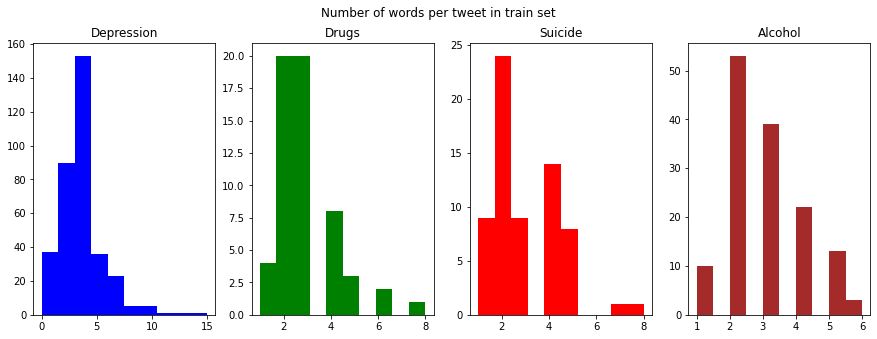

In [51]:
fig,(ax1,ax2, ax3, ax4) = plt.subplots(1,4,figsize=(15,5))

train_len = train[train['label'] == 'Depression']['text_norm'].str.split().map(lambda x: len(x))
ax1.hist(train_len,color='blue')
ax1.set_title('Depression')

train_len = train[train['label'] == 'Drugs']['text_norm'].str.split().map(lambda x: len(x))
ax2.hist(train_len,color='green')
ax2.set_title('Drugs')

train_len = train[train['label'] == 'Suicide']['text_norm'].str.split().map(lambda x: len(x))
ax3.hist(train_len,color='red')
ax3.set_title('Suicide')

train_len = train[train['label'] == 'Alcohol']['text_norm'].str.split().map(lambda x: len(x))
ax4.hist(train_len,color='brown')
ax4.set_title('Alcohol')

fig.suptitle('Number of words per tweet in train set')
plt.show()

Text(0.5, 1.0, 'test set word length')

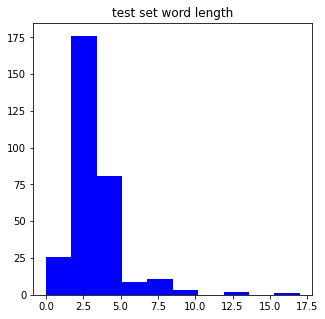

In [52]:
fig, ax = plt.subplots(figsize=(5,5))

train_len = test['text_norm'].str.split().map(lambda x: len(x))
ax.hist(train_len,color='blue')
ax.set_title('test set word length')

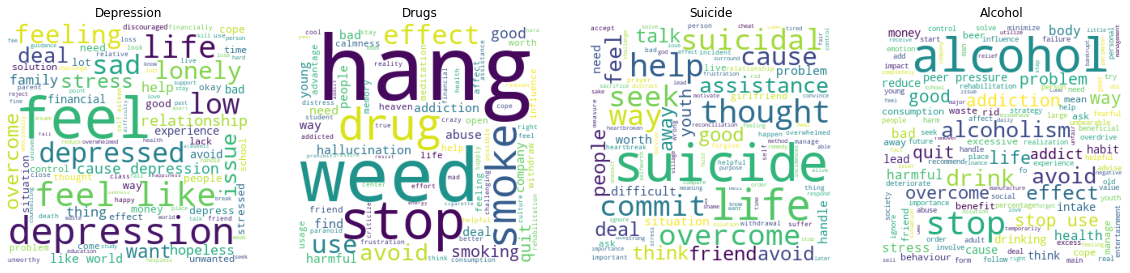

In [53]:
stopwords = set(STOPWORDS)

labels=['Depression', 'Drugs', 'Suicide', 'Alcohol']
fig, ax = plt.subplots(1,4, figsize=(20,11))
for i,s in enumerate(labels):
    
    tot_token = ''
    tot_token +=' '.join(train.loc[train['label']==s,'text_norm'])
    wordcloud = WordCloud(width=300, height=300, background_color='white',
                     stopwords = stopwords, min_font_size=6).generate(tot_token)

    ax[i].imshow(wordcloud)  
    ax[i].set_title(s)
    ax[i].axis('off')

D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


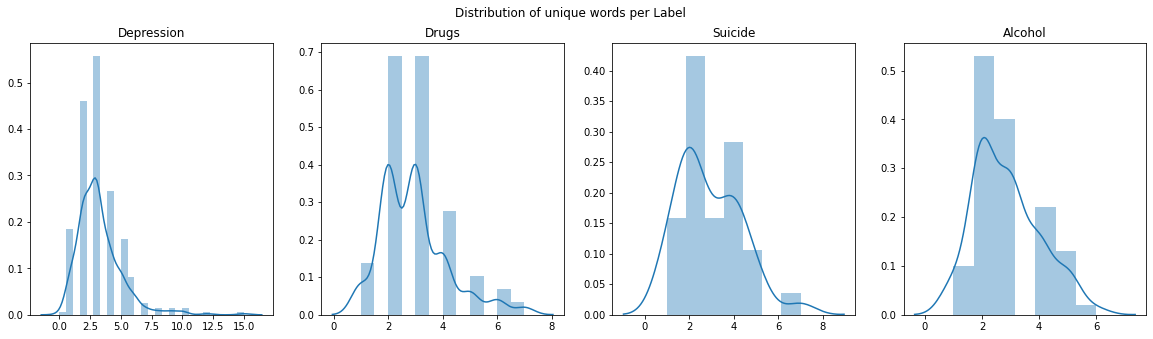

In [54]:
def distribution_unique_word(df):
    fig,ax = plt.subplots(1,4, figsize=(20,5))
    for i,s in enumerate(labels):
        new = train[train['label']==s]['text_norm'].map(lambda x: len(set(x.split())))
        sns.distplot(new.values, ax=ax[i])
        ax[i].set_title(s)
    fig.suptitle('Distribution of unique words per Label')
    fig.show()

distribution_unique_word(train)

# BERT

In [162]:
#https://github.com/javaidnabi31/Multi-Label-Text-classification-Using-BERT/blob/master/multi-label-classification-bert.ipynb
#!pip install bert-for-tf2
#!pip install sentencepiece
#!pip install wordcloud
#!pip install bert-tensorflow

In [166]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import tensorflow_hub as hub
from tensorflow.keras import layers
import bert
#from bert import run_classifier
#from bert import optimization
from bert import tokenization
from bert import modeling

import os
import collections
import pandas as pd
from datetime import datetime


from keras.utils import np_utils
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder

In [159]:
##use downloaded model, change path accordingly
BERT_VOCAB= './bert/uncased_L-12_H-768_A-12/vocab.txt'
BERT_INIT_CHKPNT = './bert/uncased_L-12_H-768_A-12/bert_model.ckpt'
BERT_CONFIG = './bert/uncased_L-12_H-768_A-12/bert_config.json'

#tokenization.validate_case_matches_checkpoint(True,BERT_INIT_CHKPNT)
#tokenizer = tokenization.FullTokenizer(vocab_file=BERT_VOCAB, do_lower_case=True)

In [111]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, labels=None):
        """Constructs a InputExample.

        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            labels: (Optional) [string]. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.labels = labels


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_ids, is_real_example=True):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_ids = label_ids,
        self.is_real_example=is_real_example



In [120]:
# creates a list of lists where each sublist contains tokenized text, the label of the text and the length of the review
Y = train['label']

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)

encoded_Y = encoder.transform(Y)

# convert integers to dummy variables (i.e. one hot encoded)
one_hot_labels = np_utils.to_categorical(encoded_Y)

[0.0, 0.0, 0.0, 1.0]

In [141]:
def create_examples(df, labels):
    """Creates examples for the training and dev sets."""
    examples = []
    for i, row in df.iterrows():
        guid = row.ID
        text_a = row.text_norm
        labels = list(one_hot_labels[i])
        examples.append(
            InputExample(guid=guid, text_a=text_a, labels=labels))
    return examples

In [142]:
TRAIN_VAL_RATIO = 0.9
LEN = train.shape[0]
SIZE_TRAIN = int(TRAIN_VAL_RATIO*LEN)

x_train = train[:SIZE_TRAIN]
x_val = train[SIZE_TRAIN:]

train_examples = create_examples(x_train, one_hot_labels)

In [143]:
def convert_examples_to_features(examples,  max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""

    features = []
    for (ex_index, example) in enumerate(examples):
        print(example.text_a)
        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[:(max_seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens += tokens_b + ["[SEP]"]
            segment_ids += [1] * (len(tokens_b) + 1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        
        labels_ids = []
        for label in example.labels:
            labels_ids.append(int(label))

        if ex_index < 0:
            logger.info("*** Example ***")
            logger.info("guid: %s" % (example.guid))
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
            logger.info("label: %s (id = %s)" % (example.labels, labels_ids))

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_ids=labels_ids))
    return features



In [149]:
# We'll set sequences to be at most 16 tokens long.
MAX_SEQ_LENGTH = 16

In [144]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1.0

# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 1000
SAVE_SUMMARY_STEPS = 500



In [155]:
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
    When running eval/predict on the TPU, we need to pad the number of examples
    to be a multiple of the batch size, because the TPU requires a fixed batch
    size. The alternative is to drop the last batch, which is bad because it means
    the entire output data won't be generated.
    We use this class instead of `None` because treating `None` as padding
    battches could cause silent errors.
    """
    
    
def convert_single_example(ex_index, example, max_seq_length,
                           tokenizer):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        return InputFeatures(
            input_ids=[0] * max_seq_length,
            input_mask=[0] * max_seq_length,
            segment_ids=[0] * max_seq_length,
            label_ids=0,
            is_real_example=False)

    tokens_a = tokenizer.tokenize(example.text_a)
    tokens_b = None
    if example.text_b:
        tokens_b = tokenizer.tokenize(example.text_b)

    if tokens_b:
        # Modifies `tokens_a` and `tokens_b` in place so that the total
        # length is less than the specified length.
        # Account for [CLS], [SEP], [SEP] with "- 3"
        _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
    else:
        # Account for [CLS] and [SEP] with "- 2"
        if len(tokens_a) > max_seq_length - 2:
            tokens_a = tokens_a[0:(max_seq_length - 2)]

    # The convention in BERT is:
    # (a) For sequence pairs:
    #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
    #  type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
    # (b) For single sequences:
    #  tokens:   [CLS] the dog is hairy . [SEP]
    #  type_ids: 0     0   0   0  0     0 0
    #
    # Where "type_ids" are used to indicate whether this is the first
    # sequence or the second sequence. The embedding vectors for `type=0` and
    # `type=1` were learned during pre-training and are added to the wordpiece
    # embedding vector (and position vector). This is not *strictly* necessary
    # since the [SEP] token unambiguously separates the sequences, but it makes
    # it easier for the model to learn the concept of sequences.
    #
    # For classification tasks, the first vector (corresponding to [CLS]) is
    # used as the "sentence vector". Note that this only makes sense because
    # the entire model is fine-tuned.
    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    if tokens_b:
        for token in tokens_b:
            tokens.append(token)
            segment_ids.append(1)
        tokens.append("[SEP]")
        segment_ids.append(1)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    labels_ids = []
    for label in example.labels:
        labels_ids.append(int(label))


    feature = InputFeatures(
        input_ids=input_ids,
        input_mask=input_mask,
        segment_ids=segment_ids,
        label_ids=labels_ids,
        is_real_example=True)
    return feature


def file_based_convert_examples_to_features(
        examples, max_seq_length, tokenizer, output_file):
    """Convert a set of `InputExample`s to a TFRecord file."""

    writer = tf.io.TFRecordWriter(output_file)

    for (ex_index, example) in enumerate(examples):
        #if ex_index % 10000 == 0:
            #tf.logging.info("Writing example %d of %d" % (ex_index, len(examples)))

        feature = convert_single_example(ex_index, example,
                                         max_seq_length, tokenizer)

        def create_int_feature(values):
            f = tf.train.Feature(int64_list=tf.train.Int64List(value=list(values)))
            return f

        features = collections.OrderedDict()
        features["input_ids"] = create_int_feature(feature.input_ids)
        features["input_mask"] = create_int_feature(feature.input_mask)
        features["segment_ids"] = create_int_feature(feature.segment_ids)
        features["is_real_example"] = create_int_feature(
            [int(feature.is_real_example)])
        if isinstance(feature.label_ids, list):
            label_ids = feature.label_ids
        else:
            label_ids = feature.label_ids[0]
        features["label_ids"] = create_int_feature(label_ids)

        tf_example = tf.train.Example(features=tf.train.Features(feature=features))
        writer.write(tf_example.SerializeToString())
    writer.close()


def file_based_input_fn_builder(input_file, seq_length, is_training,
                                drop_remainder):
    """Creates an `input_fn` closure to be passed to TPUEstimator."""

    name_to_features = {
        "input_ids": tf.io.FixedLenFeature([seq_length], tf.int64),
        "input_mask": tf.io.FixedLenFeature([seq_length], tf.int64),
        "segment_ids": tf.io.FixedLenFeature([seq_length], tf.int64),
        "label_ids": tf.io.FixedLenFeature([6], tf.int64),
        "is_real_example": tf.io.FixedLenFeature([], tf.int64),
    }

    def _decode_record(record, name_to_features):
        """Decodes a record to a TensorFlow example."""
        example = tf.parse_single_example(record, name_to_features)

        # tf.Example only supports tf.int64, but the TPU only supports tf.int32.
        # So cast all int64 to int32.
        for name in list(example.keys()):
            t = example[name]
            if t.dtype == tf.int64:
                t = tf.to_int32(t)
            example[name] = t

        return example

    def input_fn(params):
        """The actual input function."""
        batch_size = params["batch_size"]

        # For training, we want a lot of parallel reading and shuffling.
        # For eval, we want no shuffling and parallel reading doesn't matter.
        d = tf.data.TFRecordDataset(input_file)
        if is_training:
            d = d.repeat()
            d = d.shuffle(buffer_size=100)

        d = d.apply(
            tf.contrib.data.map_and_batch(
                lambda record: _decode_record(record, name_to_features),
                batch_size=batch_size,
                drop_remainder=drop_remainder))

        return d

    return input_fn


def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

In [146]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_examples) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [147]:
train_file = os.path.join('./working', "train.tf_record")
#filename = Path(train_file)
if not os.path.exists(train_file):
    open(train_file, 'w').close()

In [153]:
file_based_convert_examples_to_features(train_examples, MAX_SEQ_LENGTH, tokenizer, train_file)
#tf.logging.info("***** Running training *****")
#tf.logging.info("  Num examples = %d", len(train_examples))
#tf.logging.info("  Batch size = %d", BATCH_SIZE)
#tf.logging.info("  Num steps = %d", num_train_steps)

In [156]:
train_input_fn = file_based_input_fn_builder(
    input_file=train_file,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=True)



In [157]:


def create_model(bert_config, is_training, input_ids, input_mask, segment_ids,
                 labels, num_labels, use_one_hot_embeddings):
    """Creates a classification model."""
    model = modeling.BertModel(
        config=bert_config,
        is_training=is_training,
        input_ids=input_ids,
        input_mask=input_mask,
        token_type_ids=segment_ids,
        use_one_hot_embeddings=use_one_hot_embeddings)

    # In the demo, we are doing a simple classification task on the entire
    # segment.
    #
    # If you want to use the token-level output, use model.get_sequence_output()
    # instead.
    output_layer = model.get_pooled_output()

    hidden_size = output_layer.shape[-1].value

    output_weights = tf.get_variable(
        "output_weights", [num_labels, hidden_size],
        initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable(
        "output_bias", [num_labels], initializer=tf.zeros_initializer())

    with tf.variable_scope("loss"):
        if is_training:
            # I.e., 0.1 dropout
            output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

        logits = tf.matmul(output_layer, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)
        
        # probabilities = tf.nn.softmax(logits, axis=-1) ### multiclass case
        probabilities = tf.nn.sigmoid(logits)#### multi-label case
        
        labels = tf.cast(labels, tf.float32)
        tf.logging.info("num_labels:{};logits:{};labels:{}".format(num_labels, logits, labels))
        per_example_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits)
        loss = tf.reduce_mean(per_example_loss)

        # probabilities = tf.nn.softmax(logits, axis=-1)
        # log_probs = tf.nn.log_softmax(logits, axis=-1)
        #
        # one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)
        #
        # per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
        # loss = tf.reduce_mean(per_example_loss)

        return (loss, per_example_loss, logits, probabilities)


def model_fn_builder(bert_config, num_labels, init_checkpoint, learning_rate,
                     num_train_steps, num_warmup_steps, use_tpu,
                     use_one_hot_embeddings):
    """Returns `model_fn` closure for TPUEstimator."""

    def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
        """The `model_fn` for TPUEstimator."""

        #tf.logging.info("*** Features ***")
        #for name in sorted(features.keys()):
        #    tf.logging.info("  name = %s, shape = %s" % (name, features[name].shape))

        input_ids = features["input_ids"]
        input_mask = features["input_mask"]
        segment_ids = features["segment_ids"]
        label_ids = features["label_ids"]
        is_real_example = None
        if "is_real_example" in features:
             is_real_example = tf.cast(features["is_real_example"], dtype=tf.float32)
        else:
             is_real_example = tf.ones(tf.shape(label_ids), dtype=tf.float32)

        is_training = (mode == tf.estimator.ModeKeys.TRAIN)

        (total_loss, per_example_loss, logits, probabilities) = create_model(
            bert_config, is_training, input_ids, input_mask, segment_ids, label_ids,
            num_labels, use_one_hot_embeddings)

        tvars = tf.trainable_variables()
        initialized_variable_names = {}
        scaffold_fn = None
        if init_checkpoint:
            (assignment_map, initialized_variable_names
             ) = modeling.get_assignment_map_from_checkpoint(tvars, init_checkpoint)
            if use_tpu:

                def tpu_scaffold():
                    tf.train.init_from_checkpoint(init_checkpoint, assignment_map)
                    return tf.train.Scaffold()

                scaffold_fn = tpu_scaffold
            else:
                tf.train.init_from_checkpoint(init_checkpoint, assignment_map)

        tf.logging.info("**** Trainable Variables ****")
        for var in tvars:
            init_string = ""
            if var.name in initialized_variable_names:
                init_string = ", *INIT_FROM_CKPT*"
            #tf.logging.info("  name = %s, shape = %s%s", var.name, var.shape,init_string)

        output_spec = None
        if mode == tf.estimator.ModeKeys.TRAIN:

            train_op = optimization.create_optimizer(
                total_loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu)

            output_spec = tf.estimator.EstimatorSpec(
                mode=mode,
                loss=total_loss,
                train_op=train_op,
                scaffold=scaffold_fn)
            
        elif mode == tf.estimator.ModeKeys.EVAL:

            def metric_fn(per_example_loss, label_ids, probabilities, is_real_example):

                logits_split = tf.split(probabilities, num_labels, axis=-1)
                label_ids_split = tf.split(label_ids, num_labels, axis=-1)
                # metrics change to auc of every class
                eval_dict = {}
                for j, logits in enumerate(logits_split):
                    label_id_ = tf.cast(label_ids_split[j], dtype=tf.int32)
                    current_auc, update_op_auc = tf.metrics.auc(label_id_, logits)
                    eval_dict[str(j)] = (current_auc, update_op_auc)
                eval_dict['eval_loss'] = tf.metrics.mean(values=per_example_loss)
                return eval_dict

                ## original eval metrics
                # predictions = tf.argmax(logits, axis=-1, output_type=tf.int32)
                # accuracy = tf.metrics.accuracy(
                #     labels=label_ids, predictions=predictions, weights=is_real_example)
                # loss = tf.metrics.mean(values=per_example_loss, weights=is_real_example)
                # return {
                #     "eval_accuracy": accuracy,
                #     "eval_loss": loss,
                # }

            eval_metrics = metric_fn(per_example_loss, label_ids, probabilities, is_real_example)
            output_spec = tf.estimator.EstimatorSpec(
                mode=mode,
                loss=total_loss,
                eval_metric_ops=eval_metrics,
                scaffold=scaffold_fn)
        else:
            print("mode:", mode,"probabilities:", probabilities)
            output_spec = tf.estimator.EstimatorSpec(
                mode=mode,
                predictions={"probabilities": probabilities},
                scaffold=scaffold_fn)
        return output_spec

    return model_fn



In [160]:
OUTPUT_DIR = "./working/output"
# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    keep_checkpoint_max=1,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [161]:
bert_config = modeling.BertConfig.from_json_file(BERT_CONFIG)
model_fn = model_fn_builder(
  bert_config=bert_config,
  num_labels= len(LABEL_COLUMNS),
  init_checkpoint=BERT_INIT_CHKPNT,
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps,
  use_tpu=False,
  use_one_hot_embeddings=False)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

NameError: name 'modeling' is not defined

In [56]:
BertTokenizer = bert.bert_tokenization.FullTokenizer

# Create a BERT embedding layer by importing the BERT model from hub.KerasLayer
# The trainable parameter is set to False, which means that we will not be training the BERT embedding.
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)

# create a BERT vocabulary file in the form a numpy array
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()

# set the text to lowercase
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

# finally we pass our vocabulary_file and to_lower_case variables to the BertTokenizer object
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [58]:
tokenized_texts = [tokenizer.tokenize(text) for text in train['text_norm']]

In [63]:
# get the ids of the tokens using the convert_tokens_to_ids() of the tokenizer object
def tokenize_texts(text):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text))

tokenized_texts = [tokenize_texts(text) for text in train['text_norm']]

### Preparing Data For Training  
The text in the dataset have varying lengths but to train the model, the input sentences should be of equal length. To create sentences of equal length, one way is to pad the shorter sentences by 0s. However, this can result in a sparse matrix contain large number of 0s. The other way is to pad sentences within each batch. Since we will be training the model in batches, we can pad the sentences within the training batch locally depending upon the length of the longest sentence. To do so, we first need to find the length of each sentence.

#### One hot encode 

In [84]:
# creates a list of lists where each sublist contains tokenized text, the label of the text and the length of the review
Y = train['label']

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)

encoded_Y = encoder.transform(Y)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [85]:
encoder.classes_

array(['Alcohol', 'Depression', 'Drugs', 'Suicide'], dtype=object)

In [87]:
texts_with_len = [[text, dummy_y[i], len(text)] for i, text in enumerate(tokenized_texts)]

In [88]:
#Sort the text by length
texts_with_len.sort(key=lambda x: x[2])

# remove the length attribute from all the reviews.
sorted_texts_labels = [(text_lab[0], text_lab[1]) for text_lab in texts_with_len]

In [103]:
bert_train

<FlatMapDataset shapes: (<unknown>, <unknown>), types: (tf.int32, tf.int32)>

In [104]:
BATCH_SIZE = 32
batched_dataset = bert_train.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

In [106]:
# print the first batch and see how padding has been applied to it
#next(iter(batched_dataset))